In [1]:
import yaml
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt


In [2]:
class Airfoil:
    @classmethod
    def from_windio_airfoil(cls, airfoil: dict, R: float):
        # print(airfoil["polars"]['configuration'])
        assert len(airfoil["polars"]) == 1

        grid = np.array(airfoil["polars"][0]["c_l"]["grid"])
        return cls(
            airfoil["name"],
            grid,
            airfoil["polars"][0]["c_l"]["values"],
            airfoil["polars"][0]["c_d"]["values"],
        )

    def __init__(self, name, grid, cl, cd):
        self.name = name
        self.Cl_interp = interpolate.interp1d(grid, cl, fill_value="extrapolate")
        self.Cd_interp = interpolate.interp1d(grid, cd, fill_value="extrapolate")

    def __repr__(self):
        return f"Airfoil: {self.name}"

    def Cl(self, angle):
        return self.Cl_interp(angle)

    def Cd(self, angle):
        return self.Cd_interp(angle)


class BladeAirfoils:
    @classmethod
    def from_windio(cls, windio: dict, hub_radius, R, N=200):
        blade = windio["components"]["blade"]
        D = windio["assembly"]["rotor_diameter"]

        # Extract airfoil position grid and labels
        airfoil_grid = np.array(blade["outer_shape_bem"]["airfoil_position"]["grid"])
        airfoil_grid_adjusted = (hub_radius + airfoil_grid * (R - hub_radius)) / R
        airfoil_order = blade["outer_shape_bem"]["airfoil_position"]["labels"]

        # Create airfoil objects
        airfoils = {x["name"]: Airfoil.from_windio_airfoil(x, R) for x in windio["airfoils"]}

        # Return an instance of the class
        return cls(D, airfoil_grid_adjusted, airfoil_order, airfoils, N=N)

    def __init__(self, D, airfoil_grid, airfoil_order, airfoils, N=200):
        self.D = D
        self.airfoil_grid = airfoil_grid  # Store the grid of airfoil positions
        self.airfoil_order = airfoil_order  # Store the order of airfoils
        self.airfoils = airfoils  # Store the dictionary of airfoil objects

        # Generate aerodynamic property interpolations
        aoa_grid = np.linspace(-np.pi, np.pi, N)  # Angle of attack grid
        cl = np.array([airfoils[name].Cl(aoa_grid) for name in airfoil_order])  # Lift coefficients
        cd = np.array([airfoils[name].Cd(aoa_grid) for name in airfoil_order])  # Drag coefficients

        self.cl_interp = interpolate.RectBivariateSpline(airfoil_grid, aoa_grid, cl)
        self.cd_interp = interpolate.RectBivariateSpline(airfoil_grid, aoa_grid, cd)

    def Cl(self, x, inflow):
        return self.cl_interp(x, inflow, grid=False)

    def Cd(self, x, inflow):
        return self.cd_interp(x, inflow, grid=False)

    def __call__(self, x, inflow):
        return self.Cl(x, inflow), self.Cd(x, inflow)



class RotorDefinition:
    @classmethod
    def from_windio(cls, windio: dict):
        name = windio["name"]

        P_rated = windio["assembly"]["rated_power"]
        hub_height = windio["assembly"]["hub_height"]
        rotorspeed_max = windio["control"]["torque"]["VS_maxspd"]
        tsr_target = windio["control"]["torque"]["tsr"]

        hub_diameter = windio["components"]["hub"]["diameter"]
        hub_radius = hub_diameter / 2
        cone = windio["components"]["hub"]["cone_angle"]  # deg
        blade = windio["components"]["blade"]

        blade_length = blade["outer_shape_bem"]["reference_axis"]["z"]["values"][-1]

        N_blades = windio["assembly"]["number_of_blades"]
        D = windio["assembly"]["rotor_diameter"]

        # Rotor radius adjusted to include cone angle and hub diameter
        # R = blade_length * np.cos(np.deg2rad(cone)) + hub_radius
        R = blade_length * np.cos(cone) + hub_radius

        data_twist = blade["outer_shape_bem"]["twist"]
        data_chord = blade["outer_shape_bem"]["chord"]

        # grid including hub center and cone angle
        twist_grid = (hub_radius + np.array(data_twist["grid"]) * (R - hub_radius)) / R
        twist_func = interpolate.interp1d(twist_grid, data_twist["values"], fill_value="extrapolate")
        # grid including hub center and cone angle
        chord_grid = (hub_radius + np.array(data_chord["grid"]) * (R - hub_radius)) / R
        chord_func = interpolate.interp1d(chord_grid, data_chord["values"], fill_value="extrapolate")

        solidity_func = lambda mu: np.minimum(
            N_blades * chord_func(mu) / (2 * np.pi * np.maximum(mu, 0.0001) * R),
            1,
        )

        airfoil_func = BladeAirfoils.from_windio(windio, hub_radius, R)

        return cls(
            twist_func,
            chord_func,
            solidity_func,
            airfoil_func,
            N_blades,
            R,
            P_rated,
            rotorspeed_max,
            hub_height,
            tsr_target,
            hub_radius,
            name=name,
        )

    def __init__(
        self,
        twist_func,
        chord_func,
        solidity_func,
        airfoil_func,
        N_blades,
        R,
        P_rated,
        rotorspeed_max,
        hub_height,
        tsr_target,
        hub_radius,
        name=None,
    ):
        self.name = name
        self.N_blades = N_blades

        self.R = R
        self.P_rated = P_rated
        self.rotorspeed_max = rotorspeed_max
        self.hub_height = hub_height
        self.tsr_target = tsr_target
        self.hub_radius = hub_radius

        self.twist_func = twist_func
        self.chord_func = chord_func
        self.solidity_func = solidity_func
        self.airfoil_func = airfoil_func

    def twist(self, mu):
        return self.twist_func(mu)

    def solidity(self, mu):
        return self.solidity_func(mu)

    def clcd(self, mu, aoa):
        return self.airfoil_func(mu, aoa)


In [3]:
def evaluate_properties_vector_nearest(mu_vector, rotor_definition):
    # Evaluate twist and chord directly using vectorized functions
    twist_angles = rotor_definition.twist_func(mu_vector)
    chord_lengths = rotor_definition.chord_func(mu_vector)

    # Retrieve the airfoil grid and order from the rotor_definition
    airfoil_grid = rotor_definition.airfoil_func.airfoil_grid  # Get the grid of mu values
    airfoil_order = rotor_definition.airfoil_func.airfoil_order  # Airfoil names from the input

    # Compute distances from each mu to the airfoil grid
    distances = np.abs(mu_vector[:, None] - airfoil_grid[None, :])
    nearest_indices = np.argmin(distances, axis=1)  # Find the nearest grid index for each mu

    # Map nearest indices to airfoil names
    airfoil_names = np.array(airfoil_order)[nearest_indices]

    # Return vectors for all quantities
    return twist_angles, chord_lengths, airfoil_names, nearest_indices

In [4]:
# turbine = '/Users/stormmata/Library/Mobile Documents/com~apple~CloudDocs/Courses/Research/Code/MITRotor/MITRotor/ReferenceTurbines/IEA-15-240-RWT.yaml'
turbine = '/Users/stormmata/Library/Mobile Documents/com~apple~CloudDocs/Courses/Research/Code/MITRotor/MITRotor/ReferenceTurbines/IEA-22-280-RWT.yaml'

In [5]:
with open(turbine, "r") as f:
    data = yaml.safe_load(f)

rotor_definition = RotorDefinition.from_windio(data)

In [6]:
mu_vector1 = np.arange(0.0, 0.20, 0.01)  # 100 points from 0 to 1
mu_vector2 = np.arange(0.20, 0.90, 0.02)  # 100 points from 0 to 1
mu_vector3 = np.arange(0.90, 0.95, 0.01)  # 100 points from 0 to 1
mu_vector4 = np.arange(0.95, 1.005, 0.005)  # 100 points from 0 to 1
mu_vector  = np.concatenate((mu_vector1,mu_vector2,mu_vector3,mu_vector4))
mu_vector


array([0.   , 0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 ,
       0.09 , 0.1  , 0.11 , 0.12 , 0.13 , 0.14 , 0.15 , 0.16 , 0.17 ,
       0.18 , 0.19 , 0.2  , 0.22 , 0.24 , 0.26 , 0.28 , 0.3  , 0.32 ,
       0.34 , 0.36 , 0.38 , 0.4  , 0.42 , 0.44 , 0.46 , 0.48 , 0.5  ,
       0.52 , 0.54 , 0.56 , 0.58 , 0.6  , 0.62 , 0.64 , 0.66 , 0.68 ,
       0.7  , 0.72 , 0.74 , 0.76 , 0.78 , 0.8  , 0.82 , 0.84 , 0.86 ,
       0.88 , 0.9  , 0.91 , 0.92 , 0.93 , 0.94 , 0.95 , 0.955, 0.96 ,
       0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 , 0.995, 1.   ])

In [7]:
mu_vector * rotor_definition.R

array([  0.        ,   1.41664326,   2.83328652,   4.24992978,
         5.66657305,   7.08321631,   8.49985957,   9.91650283,
        11.33314609,  12.74978935,  14.16643261,  15.58307587,
        16.99971914,  18.4163624 ,  19.83300566,  21.24964892,
        22.66629218,  24.08293544,  25.4995787 ,  26.91622196,
        28.33286523,  31.16615175,  33.99943827,  36.83272479,
        39.66601132,  42.49929784,  45.33258436,  48.16587088,
        50.99915741,  53.83244393,  56.66573045,  59.49901697,
        62.3323035 ,  65.16559002,  67.99887654,  70.83216306,
        73.66544959,  76.49873611,  79.33202263,  82.16530915,
        84.99859568,  87.8318822 ,  90.66516872,  93.49845524,
        96.33174177,  99.16502829, 101.99831481, 104.83160133,
       107.66488786, 110.49817438, 113.3314609 , 116.16474742,
       118.99803395, 121.83132047, 124.66460699, 127.49789351,
       128.91453677, 130.33118004, 131.7478233 , 133.16446656,
       134.58110982, 135.28943145, 135.99775308, 136.70

In [10]:
twist_angles, chord_lengths, airfoil_names, airfoil_indices = evaluate_properties_vector_nearest(mu_vector, rotor_definition)

In [11]:
airfoil_indices[airfoil_indices == 0] = 1
airfoil_indices[airfoil_indices == 15] = 14

airfoil_names = np.char.add(np.char.add('"', airfoil_names), '"')

In [12]:
# Combine arrays into a dictionary or a list of lists for DataFrame
data = {
    'R': mu_vector * rotor_definition.R,
    'chord': chord_lengths,
    'thickness': np.zeros_like(chord_lengths), 
    'twist': twist_angles * 180/np.pi,
    'airfoil': airfoil_names, 
    'ID': airfoil_indices
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Save to CSV file
df.to_csv('/Users/stormmata/Downloads/22MW_values_from_yaml.csv', index=False)

In [53]:
import os

def save_airfoil_tables(blade_airfoils, output_dir="airfoil_tables", N_aoa=181):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Generate an angle of attack grid
    aoa_grid = np.linspace(-np.pi, np.pi, N_aoa)

    # Loop through each airfoil
    for airfoil_name, airfoil_obj in blade_airfoils.airfoils.items():
        # Get lift (Cl) and drag (Cd) for the angle of attack grid
        Cl_values = airfoil_obj.Cl(aoa_grid)
        Cd_values = airfoil_obj.Cd(aoa_grid)

        # Create a DataFrame with angle of attack, lift, and drag
        data = {
            "Angle of Attack (rad)": aoa_grid * 180/np.pi,
            "Lift Coefficient (Cl)": Cl_values,
            "Drag Coefficient (Cd)": Cd_values,
        }
        df = pd.DataFrame(data)

        # Save the table to a CSV file named after the airfoil
        output_file = os.path.join(output_dir, f"{airfoil_name}_aero_table.csv")
        df.to_csv(output_file, index=False, float_format="%.6f")

        print(f"Saved {airfoil_name} table to {output_file}")

# Example usage
save_airfoil_tables(rotor_definition.airfoil_func)

Saved FFA-W3-211 table to airfoil_tables/FFA-W3-211_aero_table.csv
Saved FFA-W3-241 table to airfoil_tables/FFA-W3-241_aero_table.csv
Saved FFA-W3-270blend table to airfoil_tables/FFA-W3-270blend_aero_table.csv
Saved FFA-W3-301 table to airfoil_tables/FFA-W3-301_aero_table.csv
Saved FFA-W3-330blend table to airfoil_tables/FFA-W3-330blend_aero_table.csv
Saved FFA-W3-360 table to airfoil_tables/FFA-W3-360_aero_table.csv
Saved SNL-FFA-W3-420FB table to airfoil_tables/SNL-FFA-W3-420FB_aero_table.csv
Saved SNL-FFA-W3-480FB table to airfoil_tables/SNL-FFA-W3-480FB_aero_table.csv
Saved SNL-FFA-W3-560FB table to airfoil_tables/SNL-FFA-W3-560FB_aero_table.csv
Saved FB60 table to airfoil_tables/FB60_aero_table.csv
Saved FB70 table to airfoil_tables/FB70_aero_table.csv
Saved FB80 table to airfoil_tables/FB80_aero_table.csv
Saved FB90 table to airfoil_tables/FB90_aero_table.csv
Saved circular table to airfoil_tables/circular_aero_table.csv


Text(0.5, 0, 'Radial position, $r/R$ [-]')

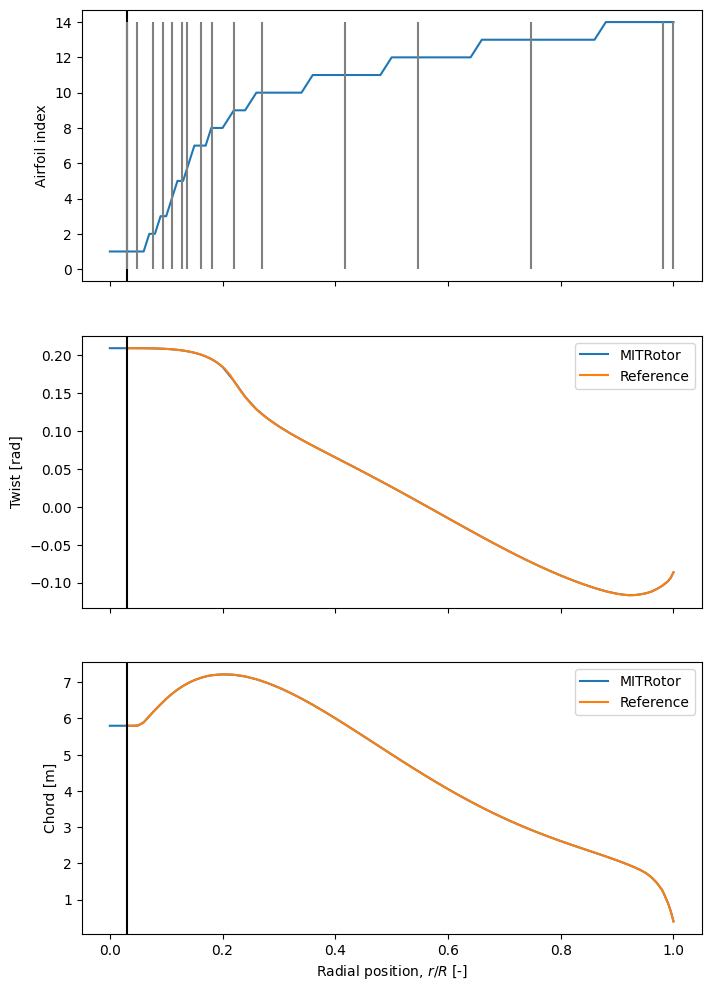

In [19]:
roverR_CT = (rotor_definition.hub_radius + np.array([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12000000000000001, 0.13, 0.14, 0.15000000000000002, 0.16, 0.16999999999999998, 0.18, 0.19, 0.2, 0.21000000000000002, 0.22000000000000003, 0.22999999999999998, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.33999999999999997, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.5800000000000001, 0.5900000000000001, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.7100000000000001, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.8400000000000001, 0.8500000000000001, 0.8600000000000001, 0.8700000000000001, 0.8800000000000001, 0.8900000000000001, 0.9000000000000001, 0.9100000000000001, 0.9200000000000002, 0.9300000000000002, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 0.995, 1.0]) * (rotor_definition.R - rotor_definition.hub_radius)) / rotor_definition.R
chord     = np.array([5.800000000000002, 5.80000750475248, 5.8000282508983085, 5.873300136154282, 6.036337335905337, 6.204051614486279, 6.3552496487646515, 6.509209919573537, 6.6436206582672535, 6.763773064804662, 6.868945375448299, 6.9570095838262125, 7.03385973300863, 7.094101851750943, 7.143199279262841, 7.181457472428118, 7.200954177924883, 7.213411228892248, 7.2197891152632225, 7.215676911218799, 7.200335839948662, 7.180397479307616, 7.151543701331798, 7.113320356781246, 7.071189168994137, 7.021828751056561, 6.967075893975885, 6.908125840505721, 6.843583440810729, 6.775436644475572, 6.703184353162563, 6.627107912815879, 6.548348551238034, 6.466228324666395, 6.381597155890247, 6.2948030968730695, 6.205612566967027, 6.114862317779713, 6.022368258297413, 5.928427076059526, 5.83354972341184, 5.737497144141892, 5.640783291001002, 5.543563753700992, 5.445815276896983, 5.34801600138044, 5.25005637198088, 5.152175669339791, 5.054658134701064, 4.957375151384219, 4.860706457472122, 4.764690166623042, 4.669323497292183, 4.574961057304324, 4.4815181588844695, 4.389098660106716, 4.297980626945867, 4.2080177052978405, 4.119380375675479, 4.032265975337243, 3.946513696298735, 3.8623275855573205, 3.7798125363802257, 3.6988322839494447, 3.6195938517549426, 3.542102096619402, 3.4662751349584298, 3.392288897244111, 3.3200636703828614, 3.249573529431582, 3.1809263929468, 3.1140130522457707, 3.0488155610808594, 2.985363104834849, 2.9235652203478444, 2.863349733906902, 2.8046812527268528, 2.74750772843051, 2.6916335405221137, 2.637018417016273, 2.5836089019288, 2.5310204451972718, 2.4793313183715466, 2.4283476116812537, 2.3774795651274556, 2.327000742032125, 2.2764241884299103, 2.225028115076343, 2.1732592445337042, 2.1201338697115015, 2.06495374404663, 2.0081846977787787, 1.947479967950722, 1.8840432099150848, 1.8163955556733704, 1.7305208699700962, 1.6134909686052534, 1.4562131635619273, 1.25015343104587, 0.9038047006328352, 0.6827250328239275, 0.4])
twist     = np.array([0.20943951023931956, 0.2094346686429543, 0.2094224788066553, 0.2093791893832636, 0.2092882356248053, 0.20916389985925368, 0.20895186676241687, 0.20861496895439127, 0.2081808791120606, 0.20754492306074132, 0.20670423153122272, 0.20563173117822106, 0.20417776481104255, 0.20236480347276584, 0.2000188103042686, 0.1969870233493221, 0.19321929389378384, 0.18824544224064516, 0.18197243631328028, 0.17338782070716946, 0.16203922896565517, 0.1515013706090463, 0.14240603823910625, 0.13410587686523948, 0.12703283266133006, 0.12093062989427726, 0.11541318902582477, 0.11027659378395241, 0.10553478591601474, 0.10102619069227003, 0.09673513267120583, 0.09262360779119087, 0.08860867308033381, 0.084712056810312, 0.08088274335448338, 0.07709354627996103, 0.07335370038438649, 0.06962492960735263, 0.06591050685334027, 0.062201578570899536, 0.05847991996424072, 0.05475206115263302, 0.0510073770238682, 0.04724076874385619, 0.04345439855317698, 0.03964341790495478, 0.03580735714833409, 0.03194705539014295, 0.028062059764830286, 0.024151912994041864, 0.020219934488267758, 0.016265889892342664, 0.012291374304658039, 0.00830245476895091, 0.0042967122119551065, 0.00027812321035551227, -0.003745586869369668, -0.007778328812976761, -0.011813045179384737, -0.015842332782284124, -0.019870693239978716, -0.02388809653659924, -0.02788915672681923, -0.03187741859925992, -0.03584004009409334, -0.03977520544794708, -0.04368349976601076, -0.047550336033799254, -0.051378891366693206, -0.055164885572705616, -0.05889404041780729, -0.06257364307278157, -0.06619456111767728, -0.06974432410210236, -0.07323265886723411, -0.07664615356288834, -0.07997626829824497, -0.08323290843442013, -0.08639872802379493, -0.08947220325678434, -0.09245979405156313, -0.09533835187866997, -0.09812042887453232, -0.10079897865786111, -0.10333797647340322, -0.10578032636668717, -0.1080739130349949, -0.11016026711030623, -0.11216939013739548, -0.11385374776959452, -0.11506806502066295, -0.11612522196540545, -0.11668548638425347, -0.11641398991779883, -0.11543981660434231, -0.11407677271087832, -0.11180229129271325, -0.10825281930430722, -0.10398111099543819, -0.09820413340779395, -0.09362298541813087, -0.08643928648210124])

airfoil_r = (rotor_definition.hub_radius + np.array([0.0, 0.02, 0.04868313468735217, 0.06649308419703373, 0.08345591801468194, 0.10220904193570582, 0.11036272014164386, 0.1364246061019374, 0.15564440587515185, 0.19665336575444797, 0.24696148735364706, 0.3992636115637571, 0.5335887750152993, 0.738938689884722, 0.9799991709122947, 1.0]) * (rotor_definition.R - rotor_definition.hub_radius)) / rotor_definition.R

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True)

ax[0].plot(mu_vector, airfoil_indices)
ax[0].axvline(rotor_definition.hub_radius/rotor_definition.R,color='k')
ax[0].vlines(airfoil_r,0,14,color='grey')
ax[0].set_ylabel('Airfoil index')
ax[1].plot(mu_vector, twist_angles, label='MITRotor')
ax[1].plot(roverR_CT, twist, label='Reference')
ax[1].axvline(rotor_definition.hub_radius/rotor_definition.R,color='k')
ax[1].legend()
ax[1].set_ylabel('Twist [rad]')
ax[2].plot(mu_vector, chord_lengths, label='MITRotor')
ax[2].plot(roverR_CT, chord, label='Reference')
ax[2].axvline(rotor_definition.hub_radius/rotor_definition.R,color='k')
ax[2].legend()
ax[2].set_ylabel('Chord [m]')
ax[2].set_xlabel('Radial position, $r/R$ [-]')


In [21]:
rotor_definition.R*2

np.float64(283.3286522516075)

In [16]:
airfoil_r/rotor_definition.R

array([0.00020928, 0.00034627, 0.00054274, 0.00066474, 0.00078092,
       0.00090938, 0.00096523, 0.00114374, 0.00127539, 0.00155629,
       0.00190088, 0.0029441 , 0.00386418, 0.00527076, 0.00692194,
       0.00705894])

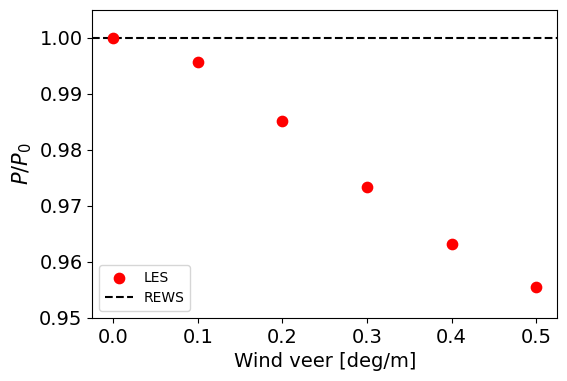

In [28]:

veer = [0,0.1,0.2,0.3,0.4,0.5]
P    = [1, 0.9957112640431055,0.9851203431356889,0.9733689175317645,0.9631002411858592,0.9554183943437755]

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(veer, P, 55, color='r',zorder=2,label='LES',alpha=1)
ax.set_ylim([0.95,1.005])
ax.axhline(1,color='k', linestyle='--',zorder=1,label='REWS')
# ax.vlines(airfoil_r,0,14,color='grey')
ax.set_ylabel('$P/P_0$',fontsize=15)
ax.set_xlabel('Wind veer [deg/m]',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)  # Increase tick label font size
ax.legend()

plt.savefig("power_both.png", dpi=600, bbox_inches='tight')
